# Проект по предсказанию результатов футбольных матчей

Описание:
Данный проект представляет собой систему машинного обучения для прогнозирования 
исходов футбольных матчей. Модель анализирует исторические данные матчей и 
атрибуты команд для предсказания трех возможных исходов: победа домашней команды, 
ничья или поражение домашней команды.

Основные особенности:
- Использование данных о матчах (Match.csv) и атрибутах команд (Team_Attributes.csv)
- Интеграция данных о стиле игры команд (скорость атаки, точность передач, дриблинг)
- Учет коэффициентов букмекерских контор как дополнительных признаков
- Сравнение двух алгоритмов: CatBoost и XGBoost

Структура данных:
- home_team_api_id - идентификатор домашней команды
- away_team_api_id - идентификатор гостевой команды  
- buildUpPlaySpeed - скорость атаки команды
- buildUpPlayPassing - точность передач
- buildUpPlayDribbling - качество дриблинга
- B365H, B365A, B365D - количество побед, ничей, поражений за последний год
- BWH, BWD, BWA - коэффициенты букмекеров на разные исходы

Метрики оценки:
- Accuracy (точность) - общая доля правильных прогнозов
- Classification report - детальная статистика по каждому классу

Этапы обработки данных:
1. Загрузка и предобработка данных
2. Создание целевой переменной (результат матча)
3. Объединение данных матчей с атрибутами команд
4. Создание признаков разницы в характеристиках команд
5. Обучение и оценка моделей машинного обучения

Используемые библиотеки:
pandas, numpy, xgboost, catboost, scikit-learn, tqdm

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# Загрузка данных
df = pd.read_csv("Match.csv")
teams = pd.read_csv("Team_Attributes.csv")
df

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25974,25975,24558,24558,2015/2016,9,2015-09-22 00:00:00,1992091,10190,10191,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25975,25976,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992092,9824,10199,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25976,25977,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992093,9956,10179,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25977,25978,24558,24558,2015/2016,9,2015-09-22 00:00:00,1992094,7896,10243,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Анализ данных

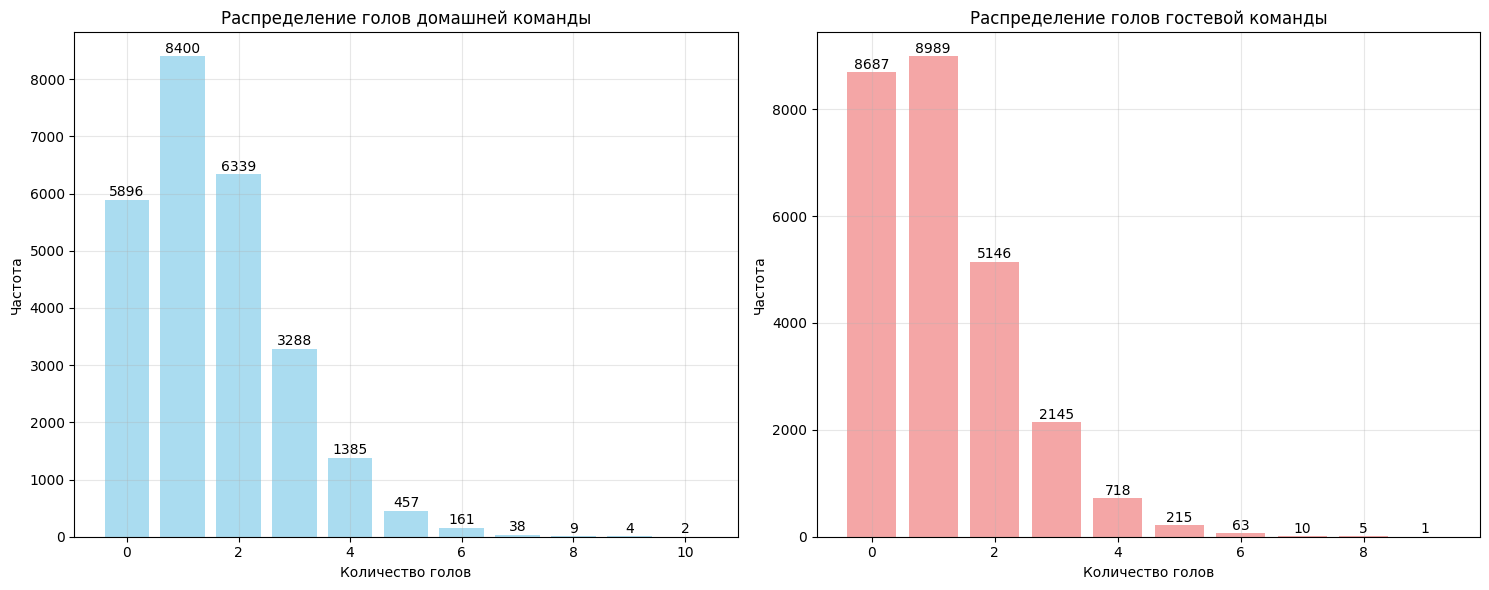

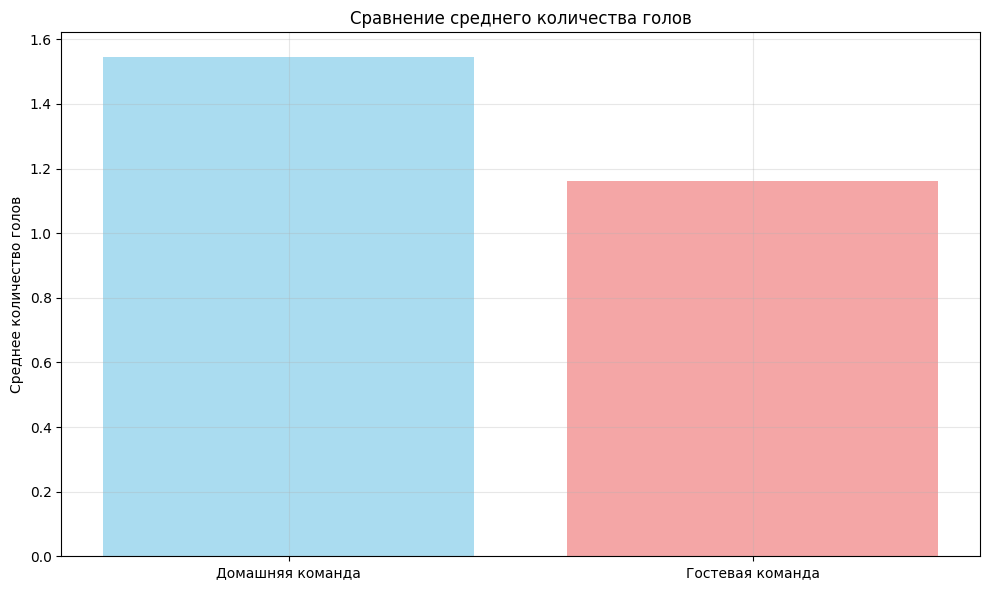

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.style.use('default')
sns.set_palette("husl")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# голы домашней команды
home_goals = df['home_team_goal'].value_counts().sort_index()
ax1.bar(home_goals.index, home_goals.values, alpha=0.7, color='skyblue')
ax1.set_xlabel('Количество голов')
ax1.set_ylabel('Частота')
ax1.set_title('Распределение голов домашней команды')
ax1.grid(True, alpha=0.3)

# значения над столбцами
for i, v in enumerate(home_goals.values):
    ax1.text(home_goals.index[i], v + 5, str(v), ha='center', va='bottom')

# голы гостевой команды
away_goals = df['away_team_goal'].value_counts().sort_index()
ax2.bar(away_goals.index, away_goals.values, alpha=0.7, color='lightcoral')
ax2.set_xlabel('Количество голов')
ax2.set_ylabel('Частота')
ax2.set_title('Распределение голов гостевой команды')
ax2.grid(True, alpha=0.3)

for i, v in enumerate(away_goals.values):
    ax2.text(away_goals.index[i], v + 5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# среднее количества голов
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Домашняя команда', 'Гостевая команда']
means = [df['home_team_goal'].mean(), df['away_team_goal'].mean()]

bars = ax.bar(categories, means, color=['skyblue', 'lightcoral'], alpha=0.7)
ax.set_ylabel('Среднее количество голов')
ax.set_title('Сравнение среднего количества голов')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [4]:
# Преобразование дат в datetime
df['date'] = pd.to_datetime(df['date'])
teams['date'] = pd.to_datetime(teams['date'])
df['date']

0       2008-08-17
1       2008-08-16
2       2008-08-16
3       2008-08-17
4       2008-08-16
           ...    
25974   2015-09-22
25975   2015-09-23
25976   2015-09-23
25977   2015-09-22
25978   2015-09-23
Name: date, Length: 25979, dtype: datetime64[ns]

In [5]:
# Сколько очков за матч получат команды
df['result'] = 1
df.loc[df['home_team_goal'] > df['away_team_goal'], 'result'] = 2
df.loc[df['home_team_goal'] < df['away_team_goal'], 'result'] = 0

In [6]:
# создаем копию, где оставим только то что нам нужно
teams_clean = teams.dropna(subset=['team_api_id', 'date', 'buildUpPlaySpeed', 'buildUpPlayPassing', 'buildUpPlayDribbling']).copy()
teams_clean

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
1,2,434,9930,2014-09-19,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
7,8,77,8485,2014-09-19,58,Balanced,64.0,Normal,62,Mixed,...,57,Normal,Organised,41,Medium,42,Press,60,Normal,Cover
8,9,77,8485,2015-09-10,59,Balanced,64.0,Normal,53,Mixed,...,63,Normal,Free Form,49,Medium,45,Press,63,Normal,Cover
13,14,614,8576,2014-09-19,59,Balanced,57.0,Normal,52,Mixed,...,52,Normal,Organised,38,Medium,47,Press,53,Normal,Cover
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,1450,244,8394,2015-09-10,52,Balanced,52.0,Normal,50,Mixed,...,57,Normal,Organised,48,Medium,43,Press,49,Normal,Cover
1450,1451,112512,8027,2014-09-19,54,Balanced,51.0,Normal,40,Mixed,...,52,Normal,Organised,44,Medium,47,Press,52,Normal,Cover
1451,1452,112512,8027,2015-09-10,54,Balanced,51.0,Normal,40,Mixed,...,52,Normal,Organised,44,Medium,47,Press,52,Normal,Cover
1456,1457,15005,10000,2014-09-19,54,Balanced,42.0,Normal,51,Mixed,...,32,Little,Organised,44,Medium,58,Press,37,Normal,Cover


In [7]:
# Добавляем атрибуты домашней команды
df_with_attrs = pd.merge_asof(
    df.sort_values('date'),
    teams_clean.sort_values('date'),
    left_on='date',
    right_on='date',
    left_by='home_team_api_id',
    right_by='team_api_id',
    direction='backward',
)
df_with_attrs = df_with_attrs.rename(columns={
    'buildUpPlaySpeed': 'buildUpPlaySpeed_home',
    'buildUpPlayPassing': 'buildUpPlayPassing_home', 
    'buildUpPlayDribbling': 'buildUpPlayDribbling_home'
})
df_with_attrs['buildUpPlaySpeed_home']

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
25974    61.0
25975     NaN
25976    63.0
25977    58.0
25978    62.0
Name: buildUpPlaySpeed_home, Length: 25979, dtype: float64

In [8]:
df_with_attrs = pd.merge_asof(
    df_with_attrs.sort_values('date'),
    teams_clean.sort_values('date'),
    left_on='date',
    right_on='date',
    left_by='away_team_api_id',
    right_by='team_api_id',
    direction='backward',
)
df_with_attrs = df_with_attrs.rename(columns={
    'buildUpPlaySpeed': 'buildUpPlaySpeed_away',
    'buildUpPlayPassing': 'buildUpPlayPassing_away',
    'buildUpPlayDribbling': 'buildUpPlayDribbling_away'
})

In [9]:
# Заполняем пропущенные значения
df_with_attrs[['buildUpPlaySpeed_home', 'buildUpPlayPassing_home', 'buildUpPlayDribbling_home']] = \
    df_with_attrs[['buildUpPlaySpeed_home', 'buildUpPlayPassing_home', 'buildUpPlayDribbling_home']].fillna(0)
df_with_attrs[['buildUpPlaySpeed_away', 'buildUpPlayPassing_away', 'buildUpPlayDribbling_away']] = \
    df_with_attrs[['buildUpPlaySpeed_away', 'buildUpPlayPassing_away', 'buildUpPlayDribbling_away']].fillna(0)

In [10]:
# Создаем признаки разницы между командами
df_with_attrs['speed_diff'] = df_with_attrs['buildUpPlaySpeed_home'] - df_with_attrs['buildUpPlaySpeed_away']
df_with_attrs['passing_diff'] = df_with_attrs['buildUpPlayPassing_home'] - df_with_attrs['buildUpPlayPassing_away']
df_with_attrs['dribbling_diff'] = df_with_attrs['buildUpPlayDribbling_home'] - df_with_attrs['buildUpPlayDribbling_away']

In [11]:
df = df.sort_values('date')
# Подготовка данных для модели
X = df_with_attrs[[
    'home_team_api_id', 'away_team_api_id', 'date','speed_diff', 'passing_diff', 'dribbling_diff', 'B365H', 'B365A', 'B365D', 'BWH', 'BWD', 'BWA'
    # 'home_team_api_id', 'away_team_api_id', 'B365H', 'B365A', 'B365D', 'BWH', 'BWD', 'BWA'
]]
y = df_with_attrs['result']
X

,home_team_api_id,away_team_api_id,date,speed_diff,passing_diff,dribbling_diff,B365H,B365A,B365D,BWH,BWD,BWA
0,10192,9931,2008-07-18,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,9930,10179,2008-07-19,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,10199,9824,2008-07-20,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,7955,10243,2008-07-20,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,6493,7955,2008-07-23,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
25974,10191,10192,2016-05-25,6.0,-29.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
25975,9931,9956,2016-05-25,11.0,-8.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
25976,7896,10190,2016-05-25,-52.0,-48.0,-46.0,NaN,NaN,NaN,NaN,NaN,NaN
25977,10199,10179,2016-05-25,2.0,14.0,-6.0,NaN,NaN,NaN,NaN,NaN,NaN


## Обучение моделей

In [12]:
# Разделение данных и обучение модели
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
model = CatBoostClassifier(random_state=42, verbose=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Оценка точности
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Поражение дома', 'Ничья', 'Победа дома']))

Accuracy: 0.4834

Classification Report:
                precision    recall  f1-score   support

Поражение дома       0.45      0.49      0.47      1561
         Ничья       0.30      0.19      0.23      1330
   Победа дома       0.56      0.65      0.61      2305

      accuracy                           0.48      5196
     macro avg       0.44      0.44      0.43      5196
  weighted avg       0.46      0.48      0.47      5196



In [13]:
def res(X, y, initial_train_ratio=0.7):
    X_numeric = X.select_dtypes(include=[np.number])
    total_samples = len(X_numeric)
    initial_train_size = int(total_samples * initial_train_ratio)
    val_size = total_samples - initial_train_size
    
    results = []
    all_predictions = []  # список для хранения всех предсказаний
    
    for i in tqdm(range(300)):
        train_end = initial_train_size + i
        test_index = initial_train_size + i
        
        X_train = X_numeric.iloc[:train_end]
        y_train = y.iloc[:train_end]
        X_test = X_numeric.iloc[test_index:test_index+1]
        y_test = y.iloc[test_index:test_index+1].values[0]
        
        model = xgb.XGBClassifier(random_state=42, verbosity=0, use_label_encoder=False, eval_metric='mlogloss')
        model.fit(X_train, y_train)
        
        y_proba = model.predict_proba(X_test)[0]
        y_pred = model.predict(X_test)[0]
        
        # сохраняем предсказание
        all_predictions.append(y_pred)
        
        results.append({
            'step': i + 1,
            'true_value': y_test,
            'predicted_class': y_pred,
            'prob_class_0': y_proba[0],
            'prob_class_1': y_proba[1], 
            'prob_class_2': y_proba[2],
            'max_probability': np.max(y_proba),
            'is_correct': y_test == y_pred,
            'training_samples': train_end
        })
    
    df_results = pd.DataFrame(results)
    
    # выводим статистику
    accuracy = df_results['is_correct'].mean()
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"\nСредняя уверенность: {df_results['max_probability'].mean():.3f}")
    
    # возвращаем результаты и предсказания
    return df_results, np.array(all_predictions)

results_df, y_pred = res(X, y, initial_train_ratio=0.7)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [07:37<00:00,  1.53s/it]


Accuracy: 0.5300

Средняя уверенность: 0.550


## Анализ результатов

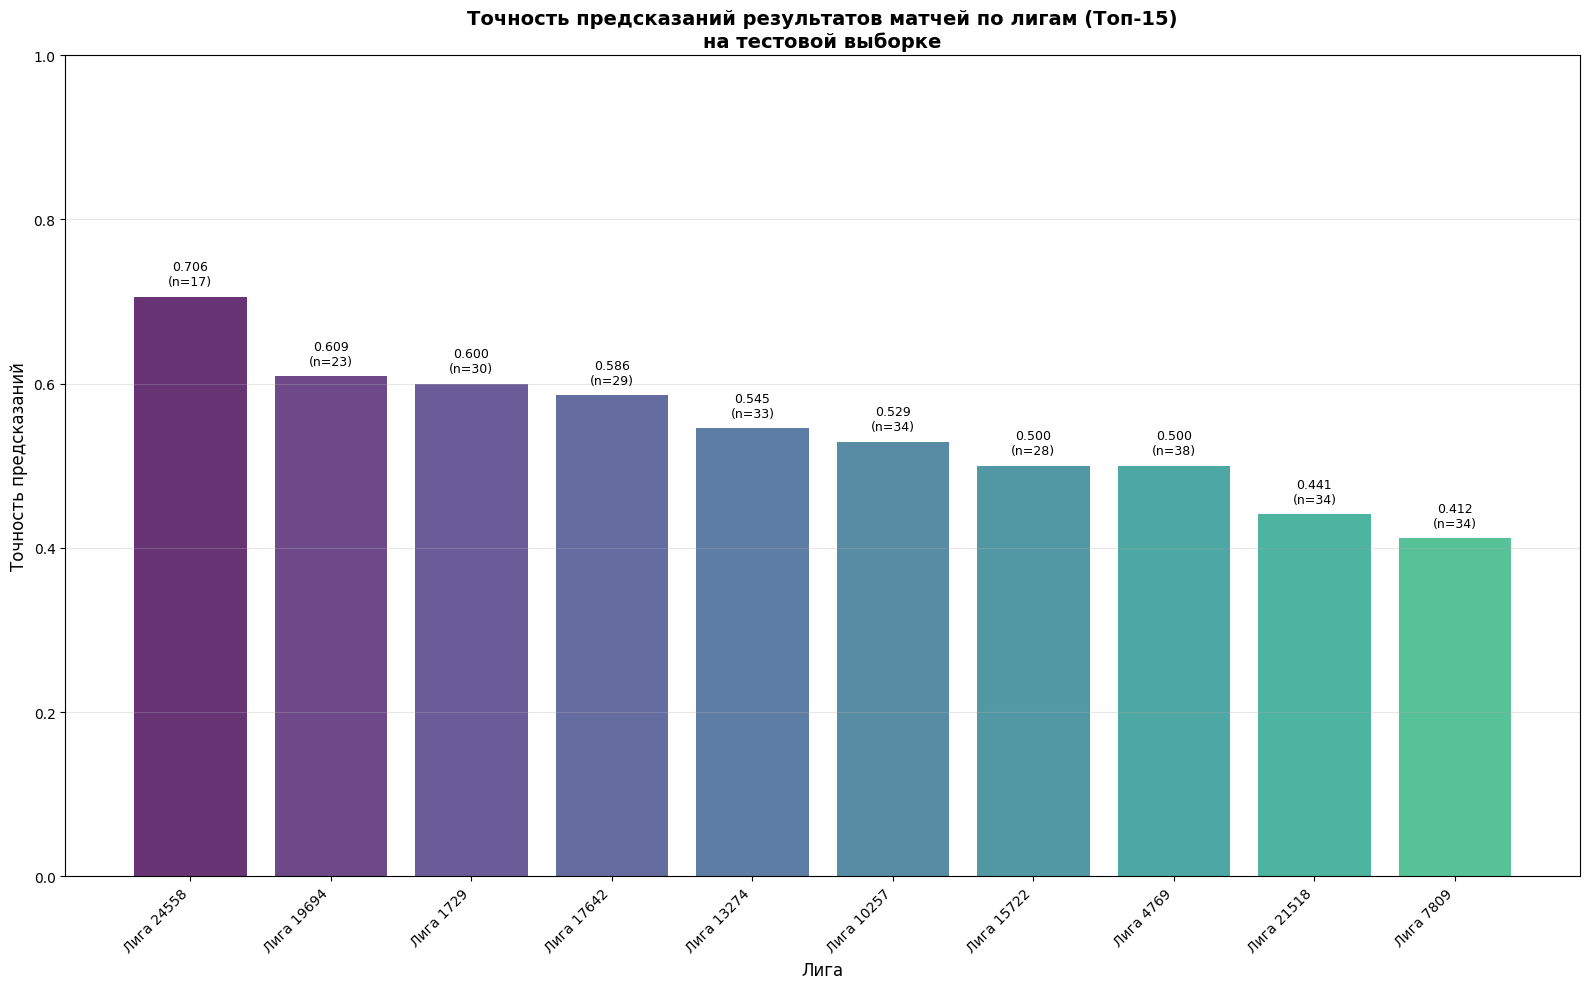

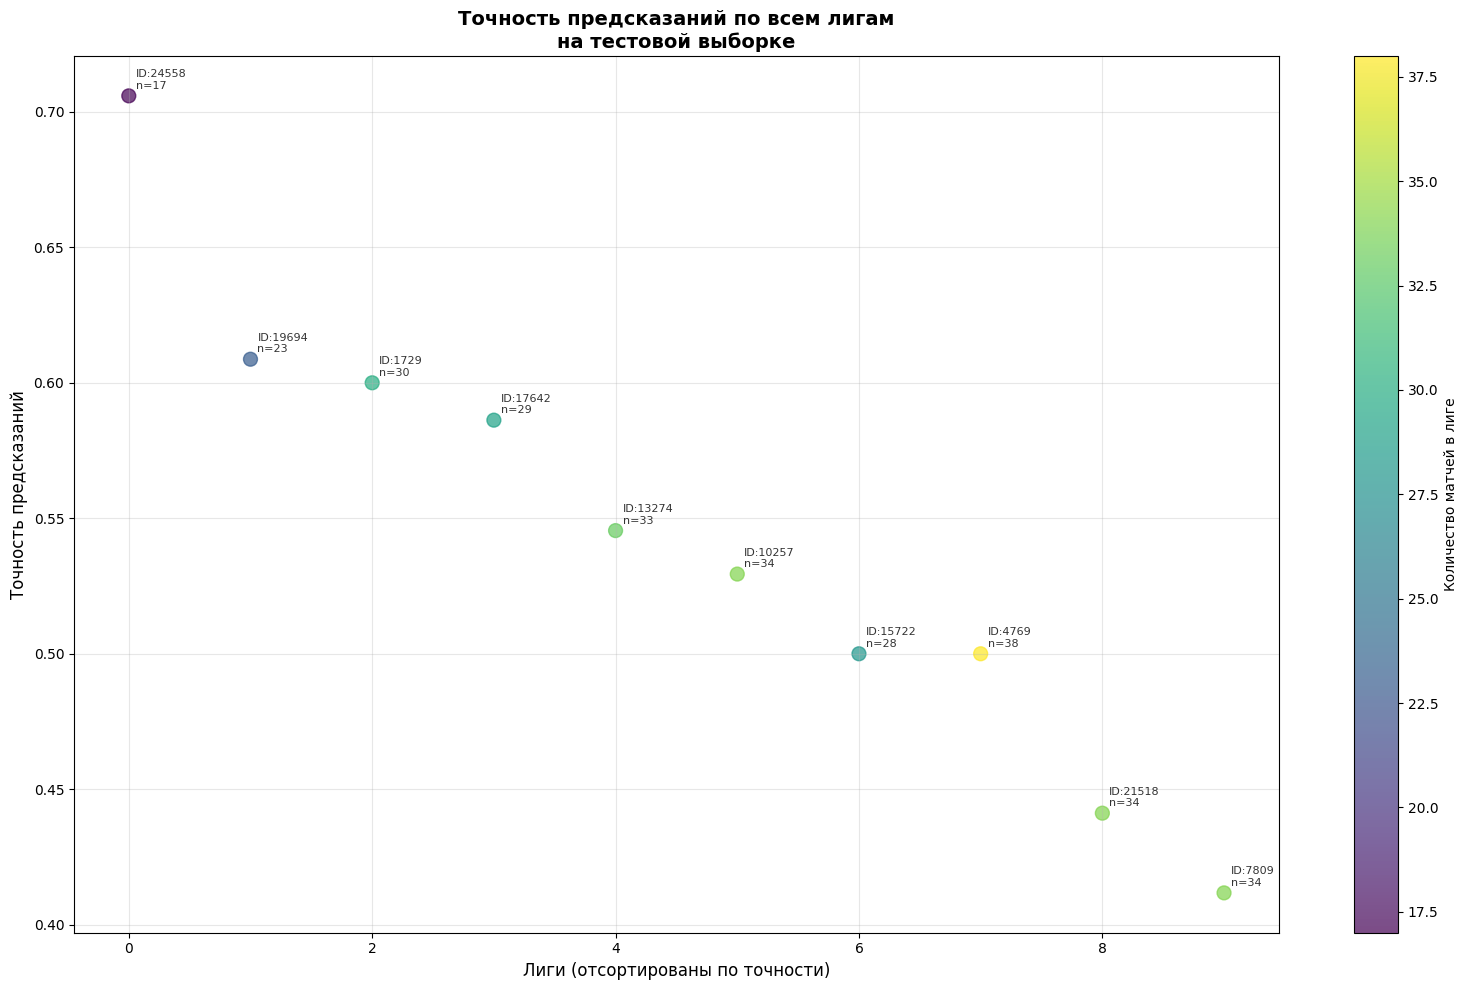

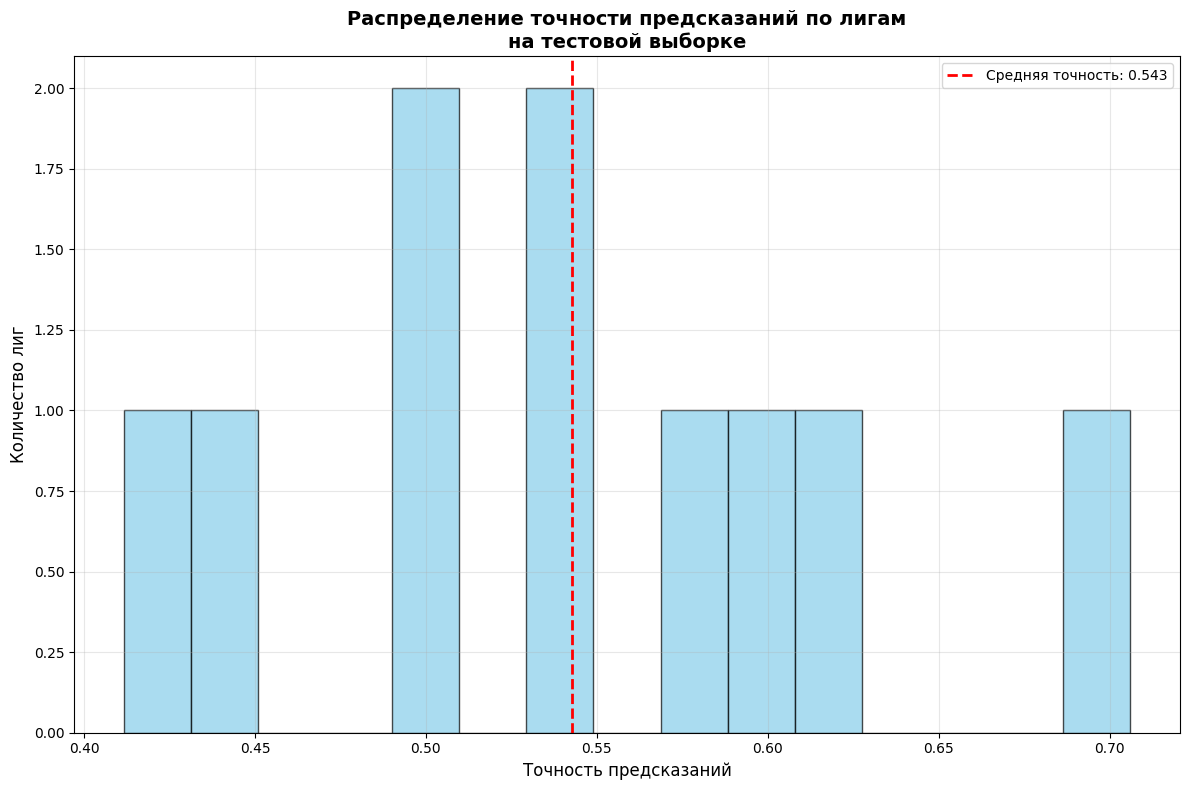

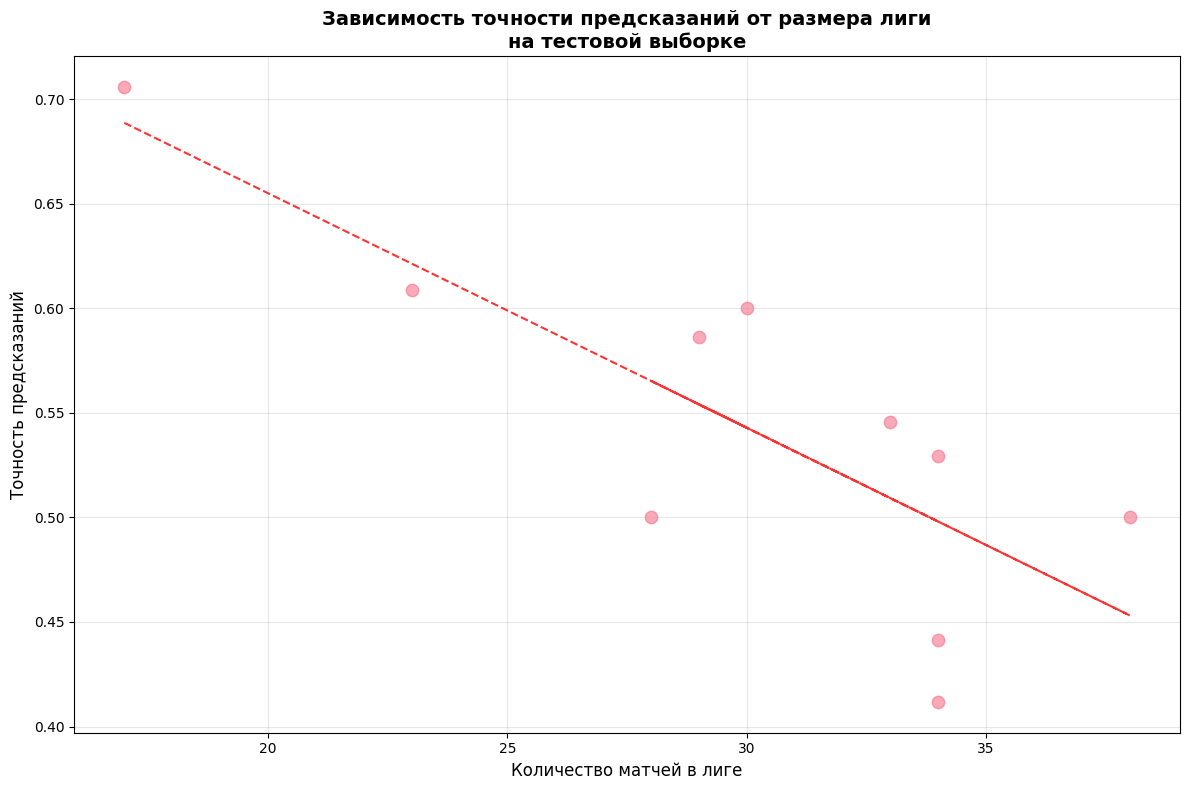

СТАТИСТИКА ТОЧНОСТИ ПРЕДСКАЗАНИЙ ПО ЛИГАМ
Общее количество лиг: 10
Средняя точность по всем лигам: 0.5429
Медианная точность: 0.5374
Стандартное отклонение: 0.0866
Лучшая лига: ID 24558 - 0.7059
Худшая лига: ID 7809 - 0.4118
Диапазон точности: 0.2941

Топ-5 лиг по точности предсказаний:
10. Лига ID 24558: 0.7059 (матчей: 17)
9. Лига ID 19694: 0.6087 (матчей: 23)
2. Лига ID 1729: 0.6000 (матчей: 30)
1. Лига ID 17642: 0.5862 (матчей: 29)
3. Лига ID 13274: 0.5455 (матчей: 33)

Топ-5 лиг с наименьшей точностью:
3. Лига ID 10257: 0.5294 (матчей: 34)
7. Лига ID 15722: 0.5000 (матчей: 28)
5. Лига ID 4769: 0.5000 (матчей: 38)
6. Лига ID 21518: 0.4412 (матчей: 34)
4. Лига ID 7809: 0.4118 (матчей: 34)


In [14]:
# Вычисляем initial_train_size для получения правильных индексов
initial_train_size = int(len(X) * 0.7)
test_indices = range(initial_train_size, initial_train_size + 300)

# Создаем test_df из исходного df_with_attrs по этим индексам
test_df = df_with_attrs.iloc[test_indices].copy()
test_df = test_df[['home_team_api_id', 'away_team_api_id', 'date', 'league_id']].copy()
test_df['result'] = y.iloc[test_indices].values
test_df['prediction'] = y_pred

# Вычисляем точность предсказаний для каждой лиги
league_accuracy = []
league_names = []
league_counts = []
league_ids = []

for league_id in test_df['league_id'].unique():
    if pd.isna(league_id):
        continue
        
    league_data = test_df[test_df['league_id'] == league_id]
    if len(league_data) > 10:  # только лиги с достаточным количеством матчей
        acc = accuracy_score(league_data['result'], league_data['prediction'])
        league_accuracy.append(acc)
        league_names.append(f'Лига {int(league_id)}')
        league_ids.append(int(league_id))
        league_counts.append(len(league_data))

# Проверяем, есть ли данные для построения графиков
if len(league_accuracy) == 0:
    print("Недостаточно данных для анализа по лигам.")
else:
    accuracy_df = pd.DataFrame({
        'league_id': league_ids,
        'league_name': league_names,
        'accuracy': league_accuracy,
        'match_count': league_counts
    }).sort_values('accuracy', ascending=False)

    # Точность предсказаний по лигам (топ-15)
    plt.figure(figsize=(16, 10))
    bars = plt.bar(accuracy_df['league_name'].head(15), 
                   accuracy_df['accuracy'].head(15), 
                   color=plt.cm.viridis(np.linspace(0, 1, 15)),
                   alpha=0.8)

    plt.xlabel('Лига', fontsize=12)
    plt.ylabel('Точность предсказаний', fontsize=12)
    plt.title('Точность предсказаний результатов матчей по лигам (Топ-15)\nна тестовой выборке', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)

    # Добавляем значения на столбцы
    for bar, acc, count in zip(bars, accuracy_df['accuracy'].head(15), accuracy_df['match_count'].head(15)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{acc:.3f}\n(n={count})', 
                 ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    # Все лиги с цветовой кодировкой по количеству матчей
    plt.figure(figsize=(16, 10))
    scatter = plt.scatter(range(len(accuracy_df)), accuracy_df['accuracy'], 
                         c=accuracy_df['match_count'], 
                         cmap='viridis', s=100, alpha=0.7)

    plt.xlabel('Лиги (отсортированы по точности)', fontsize=12)
    plt.ylabel('Точность предсказаний', fontsize=12)
    plt.title('Точность предсказаний по всем лигам\nна тестовой выборке', fontsize=14, fontweight='bold')
    plt.colorbar(scatter, label='Количество матчей в лиге')
    plt.grid(True, alpha=0.3)

    # Добавляем подписи для лучших и худших лиг
    for i, (acc, league_id, count) in enumerate(zip(accuracy_df['accuracy'], 
                                                   accuracy_df['league_id'], 
                                                   accuracy_df['match_count'])):
        if i < 5 or i > len(accuracy_df) - 6:  # Первые и последние 5
            plt.annotate(f'ID:{league_id}\nn={count}', 
                        xy=(i, acc), 
                        xytext=(5, 5), 
                        textcoords='offset points',
                        fontsize=8,
                        alpha=0.8)

    plt.tight_layout()
    plt.show()

    # Распределение точности по лигам
    plt.figure(figsize=(12, 8))
    plt.hist(accuracy_df['accuracy'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('Точность предсказаний', fontsize=12)
    plt.ylabel('Количество лиг', fontsize=12)
    plt.title('Распределение точности предсказаний по лигам\nна тестовой выборке', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

    # Добавляем вертикальную линию для средней точности
    mean_accuracy = accuracy_df['accuracy'].mean()
    plt.axvline(mean_accuracy, color='red', linestyle='--', linewidth=2, 
                label=f'Средняя точность: {mean_accuracy:.3f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Зависимость точности от количества матчей в лиге
    plt.figure(figsize=(12, 8))
    plt.scatter(accuracy_df['match_count'], accuracy_df['accuracy'], alpha=0.6, s=80)
    plt.xlabel('Количество матчей в лиге', fontsize=12)
    plt.ylabel('Точность предсказаний', fontsize=12)
    plt.title('Зависимость точности предсказаний от размера лиги\nна тестовой выборке', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

    # Добавляем линию тренда
    z = np.polyfit(accuracy_df['match_count'], accuracy_df['accuracy'], 1)
    p = np.poly1d(z)
    plt.plot(accuracy_df['match_count'], p(accuracy_df['match_count']), "r--", alpha=0.8)

    plt.tight_layout()
    plt.show()

    # Вывод статистики
    print("СТАТИСТИКА ТОЧНОСТИ ПРЕДСКАЗАНИЙ ПО ЛИГАМ")
    
    print(f"Общее количество лиг: {len(accuracy_df)}")
    print(f"Средняя точность по всем лигам: {accuracy_df['accuracy'].mean():.4f}")
    print(f"Медианная точность: {accuracy_df['accuracy'].median():.4f}")
    print(f"Стандартное отклонение: {accuracy_df['accuracy'].std():.4f}")
    if len(accuracy_df) > 0:
        print(f"Лучшая лига: ID {accuracy_df['league_id'].iloc[0]} - {accuracy_df['accuracy'].iloc[0]:.4f}")
        print(f"Худшая лига: ID {accuracy_df['league_id'].iloc[-1]} - {accuracy_df['accuracy'].iloc[-1]:.4f}")
        print(f"Диапазон точности: {accuracy_df['accuracy'].max() - accuracy_df['accuracy'].min():.4f}")

        # Топ-5 лучших лиг
        print("\nТоп-5 лиг по точности предсказаний:")
        for i, row in accuracy_df.head().iterrows():
            print(f"{i+1}. Лига ID {row['league_id']}: {row['accuracy']:.4f} (матчей: {row['match_count']})")

        # Топ-5 худших лиг
        print("\nТоп-5 лиг с наименьшей точностью:")
        for i, row in accuracy_df.tail().iterrows():
            print(f"{len(accuracy_df)-i}. Лига ID {row['league_id']}: {row['accuracy']:.4f} (матчей: {row['match_count']})")